# Regression with Amazon SageMaker XGBoost algorithm
## house prices prediction

---

---
## Contents

1. [Data Preprocessing](#Data-Preprocessing)
2. [Training the XGBoost model](#Training-the-XGBoost-model)
3. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Using SageMaker Endpoint](#Using-SageMaker-Endpoint)

---

In [2]:
import os
import boto3
import re
import copy
import time
import pandas as pd
import numpy as np
import sagemaker
from mxnet import nd
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()

bucket='sagemaker-eu-west-1-483308273948' # put your s3 bucket name here, and create s3 bucket
prefix = 'house_prices'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Preprocessing

We'll read the dataset from the existing repository into memory, for preprocessing prior to training. This processing could be done by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., a
ssuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.


In [3]:
train = pd.read_csv('data/train.csv')
label = pd.read_csv('data/label.csv', header=None)[1]

In [4]:
pd.options.display.max_columns = 999
train.head(5)

,Unnamed: 0,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtFinSF2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolArea,SaleType,SaleCondition,Exterior,Bath,Sold,Porch
0,0,60,3,65.0,8450,1,3,3,0,4,0,5,0,5,7,5,2003,2003,1,1,1,196.0,2,4,2,2,3,2,5,0,856,1,0,1,4,0,2,8,6,0,5,1,548,4,4,2,0,0,8,4,25,4,2008.166667,61
1,1,20,3,80.0,9600,1,3,3,0,2,0,24,0,2,6,8,1976,1976,1,1,2,0.0,3,4,1,2,3,0,5,0,1262,1,0,1,4,0,3,6,6,1,4,1,460,4,4,2,298,0,8,4,16,3,2007.416667,0
2,2,60,3,68.0,11250,1,0,3,0,4,0,5,0,5,7,5,2001,2002,1,1,1,162.0,2,4,2,2,3,2,5,0,920,1,0,1,4,0,2,6,6,1,4,1,608,4,4,2,0,0,8,4,25,4,2008.750000,42
3,3,70,3,60.0,9550,1,0,3,0,0,0,6,0,5,7,5,1915,1970,1,1,2,0.0,3,4,0,3,1,0,5,0,756,1,2,1,4,0,2,7,6,1,2,5,642,4,4,2,0,0,8,0,28,2,2006.166667,307
4,4,60,3,84.0,14260,1,0,3,0,2,0,15,0,5,8,5,2000,2000,1,1,1,350.0,2,4,2,2,3,2,5,0,1145,1,0,1,4,0,2,9,6,1,4,1,836,4,4,2,192,0,8,4,25,4,2009.000000,84


In [5]:
# Splitting data into validation and training and breaking dataset into data and label

# 80%-20% training to validation
train = train.as_matrix()
label = label.as_matrix()
train_size = int(train.shape[0]*0.8)

train_data  = train[:train_size,:]
val_data = train[train_size:,:]

train_label = label[:train_size]
val_label = label[train_size:]

In [6]:
import io
train_data_url = ""
validation_data_url = ""
def to_libsvm(f, labels, values):
     f.write(bytes('\n'.join(
         ['{} {}'.format(label, ' '.join(['{}:{}'.format(i + 1, el) for i, el in enumerate(vec)])) for label, vec in
          zip(labels, values)]), 'utf-8'))
     return f

def write_to_s3(fobj, bucket, key):
    return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

partitions = [('train', (train_data,train_label)), ('validation', (val_data,val_label))]
for partition_name, partition in partitions:
    print('{}: {} {}'.format(partition_name, partition[0].shape, partition[1].shape))
    labels = partition[1].tolist()
    vectors = partition[0].tolist()
    f = io.BytesIO()
    to_libsvm(f, labels, vectors)
    f.seek(0)
    key = "{}/csv/{}".format(prefix,partition_name)
    url = 's3://{}/{}'.format(bucket, key)
    print('Writing to {}'.format(url))
    write_to_s3(f, bucket, key)
    print('Done writing to {}'.format(url))
    if (partition_name == "train"):
        train_data_url = url
    else:
        validation_data_url = url

output = 's3://{}/{}'.format(bucket, prefix+'/output')

train: (1161, 54) (1161,)
Writing to s3://sagemaker-eu-west-1-483308273948/house_prices/csv/train
Done writing to s3://sagemaker-eu-west-1-483308273948/house_prices/csv/train
validation: (291, 54) (291,)
Writing to s3://sagemaker-eu-west-1-483308273948/house_prices/csv/validation
Done writing to s3://sagemaker-eu-west-1-483308273948/house_prices/csv/validation


In [19]:
output


's3://sagemaker-eu-west-1-483308273948/house_prices/output'

## Training the XGBoost model


In [7]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}
container = containers[boto3.Session().region_name]

In [8]:
%%time
import boto3
import sagemaker
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter

sess = sagemaker.Session()
region = boto3.Session().region_name

train = sagemaker.s3_input(s3_data=train_data_url,content_type='libsvm')
validation = sagemaker.s3_input(s3_data=validation_data_url,content_type='libsvm')

# Creating a new sagemaker job
estimator = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output,
                                       sagemaker_session=sess)

# Settings the job hyperparamaters
estimator.set_hyperparameters(eval_metric='rmse',
                           objective="reg:linear",
                           num_round=100)

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1), # The eta parameter shrinks the feature weights to make the boosting process more conservative.
                         'alpha' : ContinuousParameter(0, 2), # L1 regularization term on weights. Increasing this value makes models more conservative.
                         'min_child_weight' : ContinuousParameter(1, 10), # Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning.
                         'max_depth' : IntegerParameter(1, 10)} # Maximum depth of a tree.

objective_metric_name = 'validation:rmse'

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            objective_type='Minimize',
                            max_jobs=9,
                            max_parallel_jobs=3)
tuner.fit({'train': train,'validation' : validation})


INFO:sagemaker:Creating hyperparameter tuning job with name: xgboost-180614-1835


CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 270 ms


## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [10]:
xgboost_predictor = tuner.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-06-14-18-44-38-749


Arguments: train
[2018-06-14:18:41:42:INFO] Running standalone xgboost training.
[2018-06-14:18:41:42:INFO] Setting up HPO optimized metric to be : rmse
[2018-06-14:18:41:42:INFO] File size need to be processed in the node: 0.58mb. Available memory size in the node: -80.51mb
[2018-06-14:18:41:42:INFO] Insufficient memory available in the instance. Using external memory for libsvm input.                      Switch to larger instance with more RAM/distributed mode for better performance and lower cost.
[18:41:42] S3DistributionType set as FullyReplicated
[18:41:42] SparsePage::Writer Finished writing to /opt/ml/input/data/train/dtrain.r0-1.cache.row.page
[18:41:42] SparsePageSource: Finished writing to /opt/ml/input/data/train/dtrain.r0-1.cache
[18:41:42] 1161x55 matrix with 62694 entries loaded from /opt/ml/input/data/train#/opt/ml/input/data/train/dtrain.cache
[2018-06-14:18:41:42:INFO] Insufficient memory available in the instance. Using external memory for libsvm input.             

INFO:sagemaker:Creating endpoint with name xgboost-180614-1835-004-9859f1c0


--------------------------------------------------------------!

# Using SageMaker Endpoint

In [11]:
from sagemaker.predictor import json_serializer, json_deserializer

xgboost_predictor.content_type = 'text/csv'
xgboost_predictor.serializer = json_serializer
xgboost_predictor.deserializer = json_deserializer

In [13]:
from math import exp
item = 44
print("Data: \n" + str(val_data[item].tolist()) + "\n")
print("Predicted price: $" + str(round(exp(xgboost_predictor.predict(val_data[item].tolist())))))
print("Real price: $" + str(round(exp(val_label[item]))))

Data: 
[1211.0, 50.0, 3.0, 152.0, 12134.0, 1.0, 0.0, 0.0, 0.0, 4.0, 1.0, 8.0, 0.0, 0.0, 8.0, 7.0, 1988.0, 2005.0, 1.0, 1.0, 2.0, 0.0, 2.0, 4.0, 5.0, 2.0, 3.0, 2.0, 5.0, 0.0, 559.0, 1.0, 2.0, 1.0, 4.0, 0.0, 3.0, 8.0, 6.0, 0.0, 5.0, 2.0, 492.0, 4.0, 4.0, 2.0, 325.0, 0.0, 8.0, 4.0, 27.0, 2.0, 2010.5, 12.0]

Predicted price: $173675
Real price: $164000


# Predict on new data

In [14]:
test = pd.read_csv('data/test.csv')
len(test)

1459

In [15]:
prices = []
for item in test.values:
    data = {}
    for column in test.keys():
        data[column] = item[test.columns.get_loc(column)]
    data['Price'] = exp(xgboost_predictor.predict(item.tolist()))
    prices.append(data)

In [16]:
df = pd.DataFrame(prices)

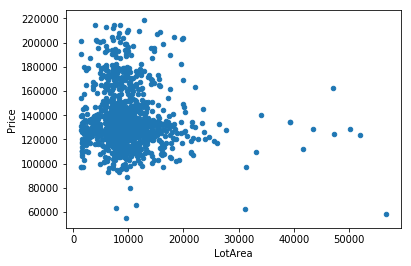

In [18]:
import matplotlib.pyplot as plt
df.plot.scatter(x='LotArea', y='Price')
plt.show()

# Delete the Endpoint

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(xgboost_predictor.endpoint)

In [ ]:
values = {}
for i,item in enumerate(val_data):
    values[i] = abs(xgboost_predictor.predict(val_data[i].tolist()) - val_label[i])
    
import operator
sorted_values = sorted(values.items(), key=operator.itemgetter(1))

print(sorted_values)

In [54]:
!aws s3 cp s3://sagemaker-eu-west-1-483308273948/house_prices/output/xgboost-180614-1835-004-9859f1c0/output/model.tar.gz ./

download: s3://sagemaker-eu-west-1-483308273948/house_prices/output/xgboost-180614-1835-004-9859f1c0/output/model.tar.gz to ./model.tar.gz


In [55]:
!tar xzvf model.tar.gz

xgboost-model


In [56]:
!pip install xgboost

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [57]:
import pickle as pkl
import xgboost as xgb
model = pkl.load(open('xgboost-model','rb' ))

In [64]:
data = xgb.DMatrix(val_data[1].tolist())

In [68]:
val_data[1]

array([1.16800000e+03, 7.00000000e+01, 3.00000000e+00, 1.20000000e+02,
       1.37280000e+04, 1.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.00000000e+00,
       0.00000000e+00, 5.00000000e+00, 6.00000000e+00, 7.00000000e+00,
       1.93500000e+03, 1.98600000e+03, 3.00000000e+00, 1.00000000e+00,
       2.00000000e+00, 0.00000000e+00, 3.00000000e+00, 4.00000000e+00,
       1.00000000e+00, 3.00000000e+00, 3.00000000e+00, 4.00000000e+00,
       5.00000000e+00, 0.00000000e+00, 1.12700000e+03, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 4.00000000e+00, 0.00000000e+00,
       2.00000000e+00, 7.00000000e+00, 6.00000000e+00, 2.00000000e+00,
       4.00000000e+00, 2.00000000e+00, 5.40000000e+02, 4.00000000e+00,
       4.00000000e+00, 2.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.00000000e+00, 4.00000000e+00, 2.30000000e+01, 2.00000000e+00,
       2.00858333e+03, 9.00000000e+01])

In [59]:
xgboost_predictor.predict(val_data[0].tolist())

11.7294397354

In [65]:
model.predict(data)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53']
expected f54 in input data

In [35]:
val_data[0]

array([1.16700000e+03, 6.00000000e+01, 3.00000000e+00, 5.80000000e+01,
       1.08520000e+04, 1.00000000e+00, 0.00000000e+00, 3.00000000e+00,
       0.00000000e+00, 4.00000000e+00, 0.00000000e+00, 8.00000000e+00,
       0.00000000e+00, 5.00000000e+00, 6.00000000e+00, 5.00000000e+00,
       2.00000000e+03, 2.00000000e+03, 1.00000000e+00, 1.00000000e+00,
       2.00000000e+00, 0.00000000e+00, 3.00000000e+00, 4.00000000e+00,
       2.00000000e+00, 2.00000000e+00, 3.00000000e+00, 2.00000000e+00,
       5.00000000e+00, 0.00000000e+00, 9.59000000e+02, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 4.00000000e+00, 0.00000000e+00,
       3.00000000e+00, 7.00000000e+00, 6.00000000e+00, 1.00000000e+00,
       4.00000000e+00, 1.00000000e+00, 4.72000000e+02, 4.00000000e+00,
       4.00000000e+00, 2.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.00000000e+00, 4.00000000e+00, 2.50000000e+01, 4.00000000e+00,
       2.00616667e+03, 3.80000000e+01])